### Unique Identifier Extraction

(currently notes)

Anecdata - folks don't really comply with the URN spec but will include URN-like things.

I don't have any plan for identifying things tagged as "cool" URIs but aren't full URLs. 


####URNs We Can't Identify

Using some regex that is not really functional:

```
^([a-z0-9.#]{0,}:([a-z0-9][a-z0-9.-]{0,31}):[a-z0-9A-Z_()+,-.:=@;$!*\'%/?#\[\]]+)
```

and that is expecting 3 parts.

Not a URN (not saying they should be, either):

 - nlm:nlmuid-67840340R-bk
 - geonode:combined_tasks
 - gov.noaa.ngdc.stp.indices:G00587
 - gov.noaa.nmfs.inport:18623

 
 
Things that are a URN according to the regex:

 - urn:nbn:nl:ui:13-01hb-3b (extracted from a rule set)
 - oai:easy.dans.knaw.nl:easy-dataset:53685 (coded as a url)
 - oai:www.mpi.nl:MPI110411
 - clarin.eu:cr1:p_1271859438204
 - urn:uuid:6426c02b-f2b1-4326-a767-2384c303faf3
 - oai:oai.datacite.org:1979342
 
 
 
 

####More generally things that are awkward

A piece of text prior to identifier extraction. 

St1958-03-31T00:00:00-111.155555685007http://services.azgs.az.gov/OnlineAccessMineFiles/M-R/MilewidePima15.pdfDocument

It's composed of a timestamp, a URL and a file type. Using the regex, we would extract more text than just the URL for the URL identifier (so it would keep the ".pdfDocument".

### About the Identifiers

There are a couple of layers of extraction. There's a set of unqualified paths (they don't need to be the full path) for known identifier locations. We can't assume that these will conform to a unique identifier specfication or structure but is being provided as some identifier by the publisher. We are taking that in good faith.


**What it extracts**

URLS: 

http://vmo.igpp.ucla.edu/data1/SAMBA/2004/Feb/S04043VLD1s.asc

https://workspace.nottingham.ac.uk/pages/metadata/viewxml.action?pageId=132225079

ftp://ftp.nmh.ac.uk/wdc/obsdata/1minval

gsiftp://vetsman.ucar.edu:2811/


Handles:

http://hdl.handle.net/10022/AC:P:449


DOIs:

http://dx.doi.org/10.7916/D85B019G

10.7916/D85B019G

doi:10.5284/1017355


Cool URIs:

(a cool URI is pretty broad here - alphanumerics between forward slashes and a couple of select punctuation chars)

samos/data/research/WTEP/2009/WTEP_20090509v30001.nc

/opendap/hyrax/TRMM_L2/TRMM_2A23/2008/087/2A23.20080327.59048.7.HDF.Z

URNs:

SC:MOD17A2.005:2042282974

urn:uuid:c813a42d-0385-4cf8-b415-3e7c3783afef


UUIDs:

0d0a763e-76af-4e24-a5fd-c3930de5bed8

MD5s: 

cbb52feebe70d4d3821727b8d5dda65c


Identifier from a defined xpath rule:

gov.noaa.ngdc.sem.goes_xrs_g00036

freezingHeightIndex

V237


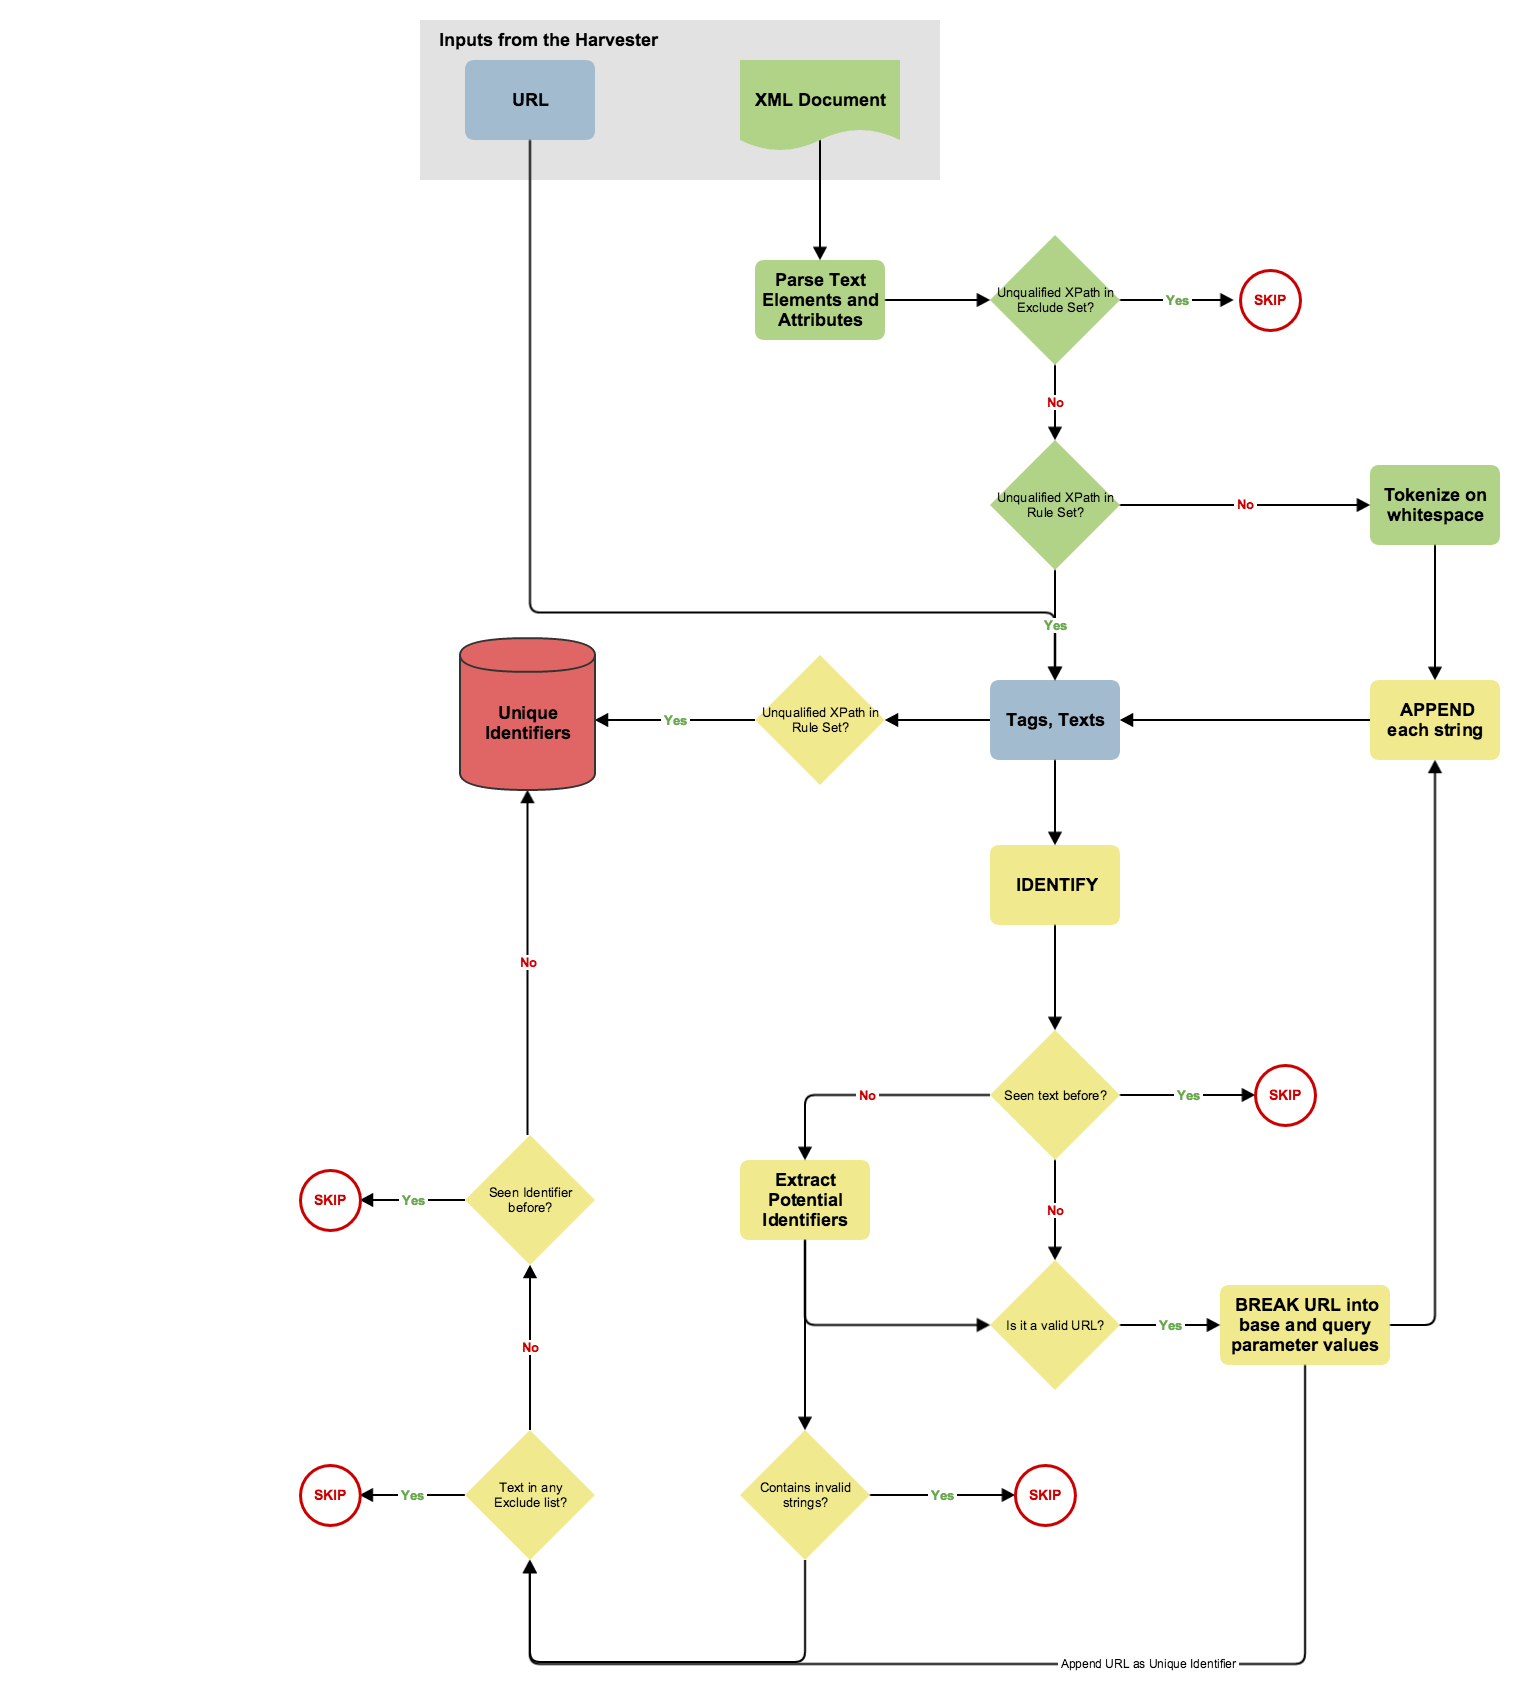

In [1]:
from IPython.display import Image
Image(filename='screenshots/unique_identifier_tree.png') 

**Identifier Extraction**

We start with two pieces of data - the URL of the harvested response and the harvested response. This process is limited to XML documents. The output is a set of potential identifiers characterized by the string identifier, the unqualified XPath of the element or attribute it was extracted from (unless it's the harvest URL), the extraction method (XPath or regular expression), and the type of identifier (URL, URN, UUID, MD5, DOI, Handle, Cool URI or text). 

Before processing, we define three types of objects. First is a set of rules related to known identifier elements in XML documents. Text found in these locations will be saved whether the strings match a known pattern or not. The assumption is that identifiers like dataset short codes or other mnemonic identifiers might be captured here. The second object is the collection of regular expressions for pattern matching. These are coded by identifier type. The third is a corpora of items to exclude from the final identifier set. These include namespace URLs, collections of URNs unrelated to dataset or metadata identifiers (EPSG codes, for example), and certain substring patterns.

We count that harvest URL as a potential identifier in its own right. The URL is added to our working set, an array of tag and text tuples. We move on to the XML document to populate the working set. For any element containing text, return the text and the unqualified XPath of the element. For text in an element with an unqualified XPath not found in the rule set, the string is tokenized based on whitespace before appending to the working set. If the XPath is in the rule set, the string is appended unmodified - that is the identifier as provided by the publisher. For any element containing an attribute, return the unqualified XPath and string. 

From that working set, we move on to identifying the identifiers. First, if the text has been processed for this document before, skip it. Next, if the XPath is found in the rule set, test the text against the known patterns. Append the text to the final set if it's a new identifier and doesn't match any exclude filter, using the type of any matching known pattern or retain the default "text" type. For any other text, compare to each of the known patterns. If it's novel and a match, add it to the final set. 

If a string is identified as a URL, it undergoes additional processing. It is not uncommon to find identifiers referenced in the query parameters so the values are stripped out and appended to the working set for identification. 

Ex: http://www.example.com/my/service?id=10.007/blob34.3466

Ex: http://www.example.com/dataset?service=iso&url=http://www.other.com/some/source/url

This set of identifiers is a large bucket - it includes any reference to an identifiable identifier anywhere in the document. These references don't necessarily contain any reliable information to understand the relationship between the document and the identifer. Internally, we might know the stated location of the identifier, ie an FGDC datsetid value, but even then we don't know if that identifier refers to the document identifier, the dataset identifier as provided by the original author or publisher, some platform identifier where the platform is some aggregator and that identifier is one generated at this republication step instead. 

Even if we knew with any certainty that we had the original identifier for the document, we face similar problems for other identifiers referenced in it. If we consider a web service description that contains a reference to some metadata record and to the source dataset of the service, can we tell which reference is to the metadata record and which is for the dataset? Are the dataset identifiers meaningful within the document only? For example, we have some number of dataset definitions with an ID element. Is the requirement for the ID only that it be unique within the description document and not that it refer to any PID of the dataset? If so, we may have an identifier but it is not externally resolvable to the dataset. Effectively, we don't have a functional identifier. 

----

Still missing from this bit of telephone game is cultural practices to manage the provenance of these records. 

I called it the telephone game based on the morphology of the identifiers themselves. How many ways can we represent a DOI? Worse, how many ways can we represent a mnemonic identifier and, of those, how many can be programmatically understood? So that's the game - we've started with this readily identifiable bit of string and, as it moves through these different representations, we make it more or less opaque. 

But the metaphor applies to the larger documents as well. We start with one representation and one conceptual understanding of a piece of metadata and those begin to change as it moves through different platforms. Different identifiers are assigned; different representational structures are applied. We don't discuss a "dialect" for the harvested representation. We can see the roles of the responsible parties but that doesn't capture changes to the identifiers nor does it provide the original reference. And the reliability of these representations vary - some services or standards are denser than others. Implementations vary, rendering even information-rich standards of limited use. [d. a. t. a. . g. o. v. csw]

Provenance is as brittle as interoperability. 

[The thing about the ISO mechanism - there's a place for a CI_Citation? or some role identification but everyone would a) have to use that Identifier structure and b) use the roles correctly and c) that still doesn't actually get at the "Is it the identifier for the metadata record or what?" But we will want to address this.]

[For web services, if we talk about mnemonic identifiers, those are more prone to collision externally. So the solution is to pair that mnemonic string with the host. However, this becomes a different identification issue given the way web services are configured related to the main portal sites. It is an issue for correctly mapping, as some third party accessor, a service or dataset. A similar mapping issue came up with DataONE. We use a unique identifier but it doesn't match the conceptual notion put forth by D1 (about versions, etc) so another identifier is minted for D1. Internally, I can map the two but no external user can. Not quite the same as mnemonic IDs/URLs from the publication side, but reasonably the same from the client end.] 

We selected DOIs for the finer-grained analysis because we know those are being minted for datasets and we know that we've harvested documents from places that are minting them. They are also cleaner than other types to extract. But how are these identifiers being used in practice (absolutely do not have enough data here I think)? Are they minted but only included in the less structured content of landing pages? Or perhaps included in the metadata platforms for bibliographic information and not the dataset and service metadata? 

In [1]:
%matplotlib inline
import pandas as pd
import json as js  # name conflict with sqla
import sqlalchemy as sqla
from sqlalchemy.orm import sessionmaker
from IPython.display import display
from IPython.display import Image

In [2]:
# grab the clean text from the rds
with open('../local/big_rds.conf', 'r') as f:
    conf = js.loads(f.read())

# our connection
engine = sqla.create_engine(conf.get('connection'))

In [4]:
# percent of responses containing at least one of a type
sql = """
select match_type,
    round(count(distinct response_id) / 608968. * 100., 2) as pct_of_all_responses
from unique_identifiers
group by match_type;
"""
df = pd.read_sql(sql, engine)
df

,match_type,pct_of_all_responses
0,cooluri,10.48
1,doi,4.72
2,hdl,2.66
3,md5,6.29
4,text,10.17
5,url,100.00
6,urn,13.11
7,uuid,8.74


So every response has at least one identifier - the source url from the harvest. How many *only* have the one URL identifier, though?

In [7]:
# responses with one identifier that is the harvest url.
sql = """
with j as (
	with i as 
	(
		select response_id, count(potential_identifier) as potentials
		from unique_identifiers
		group by response_id
	)
	select r.id, r.source_url, i.potentials, u.potential_identifier, u.match_type
	from responses r 
		join i on i.response_id = r.id
		join unique_identifiers u on u.response_id = r.id
	where i.potentials = 1 and u.match_type = 'url'
)
--select j.id, j.source_url
select count(j.id) as num
from j
where j.source_url = j.potential_identifier;
"""
df = pd.read_sql(sql, engine)
df

,num
0,212974


35% have just the one (out of 608,968 responses with unique identifiers).

In [11]:
# binned by protocol, host and type
# so this is limited to things we have identified
sql = """
with i as (
	select d.response_id, e.value as ident
	from identities d, jsonb_array_elements(d.identity::jsonb) e
	where d.identity is not null
), j as 
(
	select r.id, r.host, 
		case 
			when trim(both '"' from (i.ident->'protocol')::text) = 'OpenSearch' and i.ident ? 'service'
				then 'OpenSearch:' || trim(both '"' from (i.ident->'service'->'name')::text)
			when trim(both '"' from (i.ident->'protocol')::text) = 'OpenSearch' and i.ident ? 'resultset'
				then 'OpenSearch:Resultset'
			when trim(both '"' from (i.ident->'protocol')::text) = 'OGC' and i.ident ? 'service'
				then 'OGC:' || trim(both '"' from (i.ident->'service'->'name')::text) || ' ' || trim(both '"' from (i.ident->'service'->'request')::text)
			when trim(both '"' from (i.ident->'protocol')::text) = 'OGC' and i.ident ? 'dataset'
				then 'OGC:' || trim(both '"' from (i.ident->'dataset'->'name')::text) || ' ' || trim(both '"' from (i.ident->'dataset'->'request')::text)
            when trim(both '"' from (i.ident->'protocol')::text) = 'OGC' and i.ident ? 'resultset'
				then 'OGC:CSW Resultset'
		else trim(both '"' from (i.ident->'protocol')::text)
		end as protocol
	from responses r join i on i.response_id = r.id
), k as (
	select j.host, j.protocol, count(distinct j.id) as total
	from j 
	group by j.host, j.protocol
)

select j.protocol, j.host, u.match_type, count(distinct j.id) as count_w_type,
	round(count(distinct j.id) / max(k.total)::numeric * 100., 2) as pct_w_type,
	max(k.total) as total_responses
from j 
	inner join unique_identifiers u on u.response_id = j.id
	join k on k.host = j.host and k.protocol = j.protocol
where u.match_type != 'url' and k.total > 10
group by j.protocol, j.host, u.match_type
order by j.protocol, u.match_type, pct_w_type desc;
"""
df = pd.read_sql(sql, engine)
with pd.option_context('display.max_colwidth', 400, 'display.max_rows', 400):
    display(df)
    
# bad news - we don't have enough csw resultsets (or getcapabilities) to turn up in this table
# the cut off is a host with at least 10 responses

,protocol,host,match_type,count_w_type,pct_w_type,total_responses
0,FGDC,ecowatch.ncddc.noaa.gov,cooluri,38,50.00,76
1,FGDC,data.ioos.us,cooluri,80,43.48,184
2,FGDC,www.granit.sr.unh.edu,cooluri,22,34.38,64
3,FGDC,map.demac.udel.edu,cooluri,2,10.53,19
4,FGDC,insideidaho.org,cooluri,3,8.11,37
5,FGDC,water.usgs.gov,cooluri,27,4.80,563
6,FGDC,data.usgs.gov,cooluri,42,4.79,877
7,FGDC,cloud.insideidaho.org,cooluri,4,4.76,84
8,FGDC,www.insideidaho.org,cooluri,1,4.17,24
9,FGDC,mslapps.mt.gov,cooluri,5,2.56,195


"text" in these are potential identifiers, not matching any of the patterns, but found in one of the known identifier places such as the FGDC datsetid element. 

For XML responses we don't explicitly parse, we're probably also not catching those identifiers - the specific unqualified XPATH is not part of the rule set and, if the strings don't match another pattern, we simply don't know about them here. 


### Looking at DOIs

Let's have a poke around to see where we find DOIs in identified responses (so ISO, FGDC, OpenSearch, OGC, OAI-PMH, and THREDDS). 

In [13]:
# some wonky sql
# NOTE: this is for any host/protocol pair with more than 10 responses total
sql = """
with i as (
	select d.response_id, e.value as ident
	from identities d, jsonb_array_elements(d.identity::jsonb) e
	where d.identity is not null
), j as 
(
	select r.id, r.host, 
		case 
			when trim(both '"' from (i.ident->'protocol')::text) = 'OpenSearch' and i.ident ? 'service'
				then 'OpenSearch:' || trim(both '"' from (i.ident->'service'->'name')::text)
			when trim(both '"' from (i.ident->'protocol')::text) = 'OpenSearch' and i.ident ? 'resultset'
				then 'OpenSearch:Resultset'
			when trim(both '"' from (i.ident->'protocol')::text) = 'OGC' and i.ident ? 'service'
				then 'OGC:' || trim(both '"' from (i.ident->'service'->'name')::text) || ' ' || trim(both '"' from (i.ident->'service'->'request')::text)
			when trim(both '"' from (i.ident->'protocol')::text) = 'OGC' and i.ident ? 'dataset'
				then 'OGC:' || trim(both '"' from (i.ident->'dataset'->'name')::text) || ' ' || trim(both '"' from (i.ident->'dataset'->'request')::text)
            when trim(both '"' from (i.ident->'protocol')::text) = 'OGC' and i.ident ? 'resultset'
				then 'OGC:CSW Resultset'
		else trim(both '"' from (i.ident->'protocol')::text)
		end as protocol
	from responses r join i on i.response_id = r.id
), k as (
	select j.host, j.protocol, count(distinct j.id) as total
	from j 
	group by j.host, j.protocol
), h as 
(
	select j.protocol, count(distinct j.id) as total
	from j 
	group by j.protocol
)

select j.protocol, j.host, 
	count(distinct j.id) as count_w_doi,
	round(count(distinct j.id) / max(k.total)::numeric * 100., 2) as pct_w_doi_per_host,
	max(k.total) as total_responses_per_host,
	round(count(distinct j.id) / max(h.total)::numeric * 100., 2) as pct_w_doi_per_protocol,
	max(h.total) as total_responses_per_protocol
from j 
	inner join unique_identifiers u on u.response_id = j.id
	join k on k.host = j.host and k.protocol = j.protocol
	join h on h.protocol = j.protocol
where u.match_type = 'doi' and k.total > 10
group by j.protocol, j.host
order by j.protocol, pct_w_doi_per_host desc, j.host;
"""

df = pd.read_sql(sql, engine)
df

,protocol,host,count_w_doi,pct_w_doi_per_host,total_responses_per_host,pct_w_doi_per_protocol,total_responses_per_protocol
0,FGDC,astropedia.astrogeology.usgs.gov,35,97.22,36,0.13,26299
1,FGDC,water.usgs.gov,65,11.55,563,0.25,26299
2,FGDC,www.nodc.noaa.gov,4,10.53,38,0.02,26299
3,FGDC,sofia.usgs.gov,20,8.89,225,0.08,26299
4,FGDC,woodshole.er.usgs.gov,37,7.12,520,0.14,26299
5,FGDC,data.usgs.gov,51,5.82,877,0.19,26299
6,FGDC,pubs.usgs.gov,123,4.43,2778,0.47,26299
7,FGDC,mslapps.mt.gov,6,3.08,195,0.02,26299
8,FGDC,edg.epa.gov,3,2.27,132,0.01,26299
9,FGDC,www.ncddc.noaa.gov,1,1.75,57,0.00,26299


Something to note about the OpenSearch bins - that can include responses identified as OpenSearch result sets in addition to description documents. 

So the OpenSearch responses for globalchange.nasa.gov are actually search results, not OSDDs. I suspect the same is true of the other OS entries in this output. 

In [14]:
# let's bin just by identity just to see
sql = """
with i as (
	select d.response_id, e.value as ident
	from identities d, jsonb_array_elements(d.identity::jsonb) e
	where d.identity is not null
), j as 
(
	select r.id, r.host, 
		case 
			when trim(both '"' from (i.ident->'protocol')::text) = 'OpenSearch' and i.ident ? 'service'
				then 'OpenSearch:' || trim(both '"' from (i.ident->'service'->'name')::text)
			when trim(both '"' from (i.ident->'protocol')::text) = 'OpenSearch' and i.ident ? 'resultset'
				then 'OpenSearch:Resultset'
			when trim(both '"' from (i.ident->'protocol')::text) = 'OGC' and i.ident ? 'service'
				then 'OGC:' || trim(both '"' from (i.ident->'service'->'name')::text) || ' ' || trim(both '"' from (i.ident->'service'->'request')::text)
			when trim(both '"' from (i.ident->'protocol')::text) = 'OGC' and i.ident ? 'dataset'
				then 'OGC:' || trim(both '"' from (i.ident->'dataset'->'name')::text) || ' ' || trim(both '"' from (i.ident->'dataset'->'request')::text)
            when trim(both '"' from (i.ident->'protocol')::text) = 'OGC' and i.ident ? 'resultset'
				then 'OGC:CSW Resultset'
        else trim(both '"' from (i.ident->'protocol')::text)
		end as protocol
	from responses r join i on i.response_id = r.id
), k as (
	select j.protocol, count(distinct j.id) as total
	from j 
	group by j.protocol
)

select j.protocol, count(distinct j.id) as count_w_doi,
	round(count(distinct j.id) / max(k.total)::numeric * 100., 2) as pct_w_doi,
	max(k.total) as total_responses
from j 
	inner join unique_identifiers u on u.response_id = j.id
	join k on k.protocol = j.protocol
where u.match_type = 'doi'
group by j.protocol
order by j.protocol, pct_w_doi desc;
"""

df = pd.read_sql(sql, engine)
df

,protocol,count_w_doi,pct_w_doi,total_responses
0,FGDC,396,1.51,26299
1,ISO,420,2.13,19689
2,OGC:WFS GetCapabilities,3,0.73,412
3,OpenSearch:Resultset,4,0.46,874


Yikes. I don't expect much from OGC and OpenSearch.

In [8]:
# bin just by host just for more of the doi set

sql = """
with k as (
	select host, count(distinct id) as total
	from responses 
	group by host
)
select j.host, count(distinct j.id) as count_w_doi,
	round(count(distinct j.id) / max(k.total)::numeric * 100., 2) as pct_w_doi,
	max(k.total) as total_responses
from responses j 
	inner join unique_identifiers u on u.response_id = j.id
	join k on k.host = j.host
where u.match_type = 'doi' and k.total > 10
group by j.host
order by pct_w_doi desc;
"""

df = pd.read_sql(sql, engine)
with pd.option_context('display.max_rows', 175):
    display(df)

,host,count_w_doi,pct_w_doi,total_responses
0,observer.gsfc.nasa.gov,25,100.00,25
1,www.geosci-instrum-method-data-syst.net,43,97.73,44
2,www.earth-syst-sci-data.net,119,96.75,123
3,www.icpsr.umich.edu,1757,95.96,1831
4,www.earth-syst-sci-data-discuss.net,23,95.83,24
5,api.gbif.org,276,95.83,288
6,www.openaccessrepository.it,20,95.24,21
7,oai.datacite.org,58,95.08,61
8,esds.ac.uk,1086,94.52,1149
9,www1.usgs.gov,577,94.13,613


In [10]:
# where do we find the DOIs in the XML?
# note here that the doi can be embedded in some block of text
# the element may not be directly related to identifiers

sql = """
select tag, count(potential_identifier) as num
from unique_identifiers
where match_type = 'doi'
group by tag
order by num desc;
"""

df = pd.read_sql(sql, engine)
with pd.option_context('display.max_colwidth', 600, 'display.max_rows', 400):
    display(df)

,tag,num
0,GranuleMetaDataFile/GranuleURMetaData/PSAs/PSA/PSAValue,11264
1,dc/identifier,10354
2,art/bm/refgrp/bibl/xrefbib/pubidlist/pubid,2741
3,codeBook/stdyDscr/citation/holdings/@URI,2130
4,article/back/ref-list/ref/mixed-citation,1924
5,RDF/Description/sameAs/@resource,1890
6,codeBook/stdyDscr/dataAccs/setAvail/accsPlac/@URI,1728
7,OAI-PMH/ListRecords/record/metadata/dc/identifier,1579
8,article/back/ref-list/ref/mixed-citation/ext-link/@href,1446
9,RDF/Dataset/relation/Description/value,1205


They're all over the place in the FGDC/ISO. (The empty "tag" is likely a URL extraction from the harvest URL and not pulled from something within the XML itself.)

In [5]:
# looking at specific iso/fgdc locations JUST FOR THE DOIs
sql = """
select tag, protocol, count(distinct response_id) as num
from doi_identifiers_in_md
group by tag, protocol
order by protocol, num desc, tag;
"""

df = pd.read_sql(sql, engine)
with pd.option_context('display.max_colwidth', 600, 'display.max_rows', 400):
    display(df)

,tag,protocol,num
0,metadata/idinfo/crossref/citeinfo/onlink,FGDC,115
1,metadata/idinfo/citation/citeinfo/lworkcit/citeinfo/onlink,FGDC,113
2,metadata/idinfo/descript/abstract,FGDC,50
3,metadata/distinfo/stdorder/digform/digtopt/onlinopt/computer/networka/networkr,FGDC,48
4,metadata/dataqual/lineage/srcinfo/srccite/citeinfo/onlink,FGDC,41
5,metadata/dataqual/lineage/procstep/procdesc,FGDC,27
6,metadata/idinfo/datacred,FGDC,18
7,metadata/idinfo/citation/citeinfo/lworkcit/citeinfo/serinfo/issue,FGDC,17
8,metadata/idinfo/citation/citeinfo/onlink,FGDC,11
9,metadata/distinfo/stdorder/digform/digtopt/onlinopt/accinstr,FGDC,9


So in both, it's a lot of cross references - lists of paper citations. 

We don't see many DOIs in the ISO ditation Identifier elements:

 	MI_Metadata/identificationInfo/MD_DataIdentification/citation/CI_Citation/identifier/
    
where we might expect to see the identifier for the dataset object. 

###What about the locations of other identifier types?

So anything not a URL (we see a TON related to RDF documents, those documents are more often data objects) and with a root element related to a known metadata or service standard.

In [5]:
# the average number of identifiers in a response for a tag and match type pair.

sql = """
with i as 
(
	select response_id, tag, match_type, count(potential_identifier) as num
	from unique_identifiers
	where match_type != 'url' and tag != ''
		and (
			tag ilike 'MI_Metadata/%%'
			or tag ilike 'MD_Metadata/%%'
			or tag ilike 'metadata/%%'
			or tag ilike 'OAI-PMH/%%'
			or tag ilike 'SensorML/%%'
			or tag ilike '%%_Capabilities/%%'
			or tag ilike 'Capabilities/%%'
			or tag ilike 'DescribeSensorResponse/%%'
			or tag ilike 'DIF/%%'
			or tag ilike 'DS_Series/%%'
			or tag ilike 'eml/%%'
			or tag ilike 'GetRecordByIdResponse/%%'
			or tag ilike 'GetRecordsResponse/%%'
		)
	group by response_id, tag, match_type
)

select tag, match_type, round(avg(num), 2) as avg_ids
from i
group by tag, match_type
order by tag, avg_ids DESC;
"""

df = pd.read_sql(sql, engine)
with pd.option_context('display.max_colwidth', 600, 'display.max_rows', 900):
    display(df)

,tag,match_type,avg_ids
0,Capabilities/Contents/CoverageSummary/Metadata/@href,uuid,1.00
1,Capabilities/Contents/ObservationOfferingList/ObservationOffering/featureOfInterest/@href,urn,1.00
2,Capabilities/Contents/ObservationOfferingList/ObservationOffering/name,urn,326.00
3,Capabilities/Contents/ObservationOfferingList/ObservationOffering/procedure/@href,urn,220.20
4,Capabilities/OperationsMetadata/ExtendedCapabilities/Conformity/Specification/ResourceLocator/URL,urn,1.00
5,Capabilities/OperationsMetadata/Operation/DCP/HTTP/Post/@href,cooluri,1.00
6,Capabilities/OperationsMetadata/Operation/Parameter/AllowedValues/Value,urn,3.00
7,Capabilities/OperationsMetadata/Operation/Parameter/Value,urn,1.00
8,capabilities/urls/a/@cache,cooluri,2.00
9,DescribeSensorResponse/description/SensorDescription/data/System/components/ComponentList/component/Component/identification/IdentifierList/identifier/@name,text,2.00


In [6]:
# let's just do sums
sql = """
select tag, match_type, count(potential_identifier) as num
from unique_identifiers
where match_type != 'url' and tag != ''
	and (
		tag ilike 'MI_Metadata/%%'
		or tag ilike 'MD_Metadata/%%'
		or tag ilike 'metadata/%%'
		or tag ilike 'OAI-PMH/%%'
		or tag ilike 'SensorML/%%'
		or tag ilike '%%_Capabilities/%%'
		or tag ilike 'Capabilities/%%'
		or tag ilike 'DescribeSensorResponse/%%'
		or tag ilike 'DIF/%%'
		or tag ilike 'DS_Series/%%'
		or tag ilike 'eml/%%'
		or tag ilike 'GetRecordByIdResponse/%%'
		or tag ilike 'GetRecordsResponse/%%'
	)
group by tag, match_type
order by tag, num DESC;
"""

df = pd.read_sql(sql, engine)
with pd.option_context('display.max_colwidth', 600, 'display.max_rows', 900):
    display(df)

,tag,match_type,num
0,Capabilities/Contents/CoverageSummary/Metadata/@href,uuid,40
1,Capabilities/Contents/ObservationOfferingList/ObservationOffering/featureOfInterest/@href,urn,8
2,Capabilities/Contents/ObservationOfferingList/ObservationOffering/name,urn,326
3,Capabilities/Contents/ObservationOfferingList/ObservationOffering/procedure/@href,urn,2202
4,Capabilities/OperationsMetadata/ExtendedCapabilities/Conformity/Specification/ResourceLocator/URL,urn,9
5,Capabilities/OperationsMetadata/Operation/DCP/HTTP/Post/@href,cooluri,1
6,Capabilities/OperationsMetadata/Operation/Parameter/AllowedValues/Value,urn,3
7,Capabilities/OperationsMetadata/Operation/Parameter/Value,urn,3
8,capabilities/urls/a/@cache,cooluri,2
9,DescribeSensorResponse/description/SensorDescription/data/System/components/ComponentList/component/Component/identification/IdentifierList/identifier/@name,text,2


I'll note that you'll see XPaths for @href attributes but referencing a UUID type. In those cases, there will be a matching URL identifier that contains the UUID at that element. We're capturing the URL as one identifier and the UUID referenced in it as another. 

We'll start with, certainly from the less filtered list of XPaths and identifier types, that there remains sets of strings that most likely meet our criteria for exclusion. This brings up a larger issue with this - for some standards, we have defined, known locations for metadata and dataset identifiers\*. So we can focus on extracting those well-known things from well-known standards. However, when we do this, we overlook two things. First, we will miss references to other entities elsewhere in these documents, in locations we're not parsing. So we're missing references to objects. Second, it assumes that we understand everything about the systems publishing data - we privilege certain representations over others and that both limits the discoverability of the objects (we ignore paltforms using a different service) and the understanding of the re-use of these objects. (Re-use is not quite right - it's not capturing references to objects in the way that we probably actually want to.)

"Cool" URI extraction also catches base64-encoded strings. We didn't want to parse those to know what they are but there doesn't appear to be a terribly reliable way to identify them through the XML structures (no xsd:base64 flag or something and, even if there were, it's not likely to be consistently used).

So, again very broad filters to get at unknown XML structures to try to capture as many relationships as possible to start. 


\* This assumes ideal use, obviously.

In [15]:
# percentages by protocol and type
sql = """
with i as (
	select d.response_id, e.value as ident
	from identities d, jsonb_array_elements(d.identity::jsonb) e
	where d.identity is not null
), j as 
(
	select r.id, r.host, 
		case 
			when trim(both '"' from (i.ident->'protocol')::text) = 'OpenSearch' and i.ident ? 'service'
				then 'OpenSearch:' || trim(both '"' from (i.ident->'service'->'name')::text)
			when trim(both '"' from (i.ident->'protocol')::text) = 'OpenSearch' and i.ident ? 'resultset'
				then 'OpenSearch:Resultset'
			when trim(both '"' from (i.ident->'protocol')::text) = 'OGC' and i.ident ? 'service'
				then 'OGC:' || trim(both '"' from (i.ident->'service'->'name')::text) || ' ' || trim(both '"' from (i.ident->'service'->'request')::text)
			when trim(both '"' from (i.ident->'protocol')::text) = 'OGC' and i.ident ? 'dataset'
				then 'OGC:' || trim(both '"' from (i.ident->'dataset'->'name')::text) || ' ' || trim(both '"' from (i.ident->'dataset'->'request')::text)
            when trim(both '"' from (i.ident->'protocol')::text) = 'OGC' and i.ident ? 'resultset'
				then 'OGC:CSW Resultset'
		else trim(both '"' from (i.ident->'protocol')::text)
		end as protocol
	from responses r join i on i.response_id = r.id
), k as (
	select j.protocol, count(distinct j.id) as total
	from j 
	group by j.protocol
)

select j.protocol, u.match_type, count(distinct j.id) as count_w_type,
	round(count(distinct j.id) / max(k.total)::numeric * 100., 2) as pct_w_type,
	max(k.total) as total_responses
from j 
	inner join unique_identifiers u on u.response_id = j.id
	join k on k.protocol = j.protocol
where u.match_type != 'url'
group by j.protocol, u.match_type
order by j.protocol, u.match_type, pct_w_type desc;
"""

df = pd.read_sql(sql, engine)
df

,protocol,match_type,count_w_type,pct_w_type,total_responses
0,FGDC,cooluri,316,1.20,26299
1,FGDC,doi,396,1.51,26299
2,FGDC,md5,403,1.53,26299
3,FGDC,text,1280,4.87,26299
4,FGDC,urn,261,0.99,26299
5,FGDC,uuid,7602,28.91,26299
6,ISO,cooluri,238,1.21,19689
7,ISO,doi,420,2.13,19689
8,ISO,md5,3756,19.08,19689
9,ISO,text,11500,58.41,19689
